In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
from scipy.stats import norm
%matplotlib notebook
import matplotlib as mpl
import matplotlib.patches as patches
from datetime import datetime
plt.style.use('seaborn')



In [2]:
def get_gaussian_weights(df, value, stds):
    
    '''
    return the weights for the time, longitude, and latitude for interpolation
    Uses the Gaussian distribution 
    
    param: values = list with [longitude, latitude, time] of that point
    param: stds = list with custom stds for [time, lon, lat]
    '''
    
    lon, lat, time = tuple(value)
    lon_std, lat_std, time_std = tuple(stds)
    
    z_lon = (df['Lon'] - lon) / lon_std
    z_lat = (df['Lat'] - lat) / lat_std
    z_time = (df['secDay'] - time) / time_std
    
    # finds the weights
    w_lon = norm.pdf(z_lon)
    w_lat = norm.pdf(z_lat)
    w_time = norm.pdf(z_time)
    
    return w_lon, w_lat, w_time

In [3]:
def get_data_for_heatmap(df, lons, lats, time, dists, heatmap_size, col_name, time_factor=1, size_factor=1, use_time=True):
    
    
    dist_lon, dist_lat, dist_time = tuple(dists) 
    stds=[dist_lon * size_factor, dist_lat * size_factor, dist_time * time_factor]

    data = np.zeros((heatmap_size, heatmap_size))
    for i, lat in enumerate(lats):
        
        data_arr = []
        
        for lon in lons:
            w_lon, w_lat, w_time = get_gaussian_weights(df, (lon, lat, time), stds=stds)
            
            if not use_time:
                w_time = np.ones_like(w_time)
            
            X = df[col_name].values
            val = np.sum(X * w_time * w_lon * w_lat) / np.sum(w_time * w_lon * w_lat)            
            data_arr.append(val)
        
        data[i, :] = data_arr
        
    return data

In [4]:
NW = (-70.14655, 43.72273)
NE = (-70.14619, 43.72253)
SE = (-70.14876, 43.72015)
SW = (-70.14911, 43.72035)
corners = [NW, NE, SE, SW]

In [5]:
def get_boundary_box(corners, R=6378137):
    '''
    Corners follow the order NW, NE, SE, SW, (longitude, latitude)
    
    returns: upperbound, lower bound, right bound, left bound
    '''
    northmost = max(corners, key=lambda x: x[0])
    southmost = min(corners, key=lambda x: x[0])
    eastmost = max(corners, key=lambda x: x[1])
    westmost = min(corners, key=lambda x: x[1])  
    
    def get_coords_from_offsets(dn, de, coord):
        
        lon, lat = coord
        
        #Coordinate offsets in radians
        dLat = dn/R
        dLon = de/(R*np.cos(np.pi*lat/180))

        #//OffsetPosition, decimal degrees
        latO = lat + dLat * 180/np.pi
        lonO = lon + dLon * 180/np.pi 
        return (lonO, latO)
    
    # offsets in meters for north
    dn = 300
    de = 0
    
    _, north_lat = get_coords_from_offsets(dn, de, northmost)
    
    # offsets in meters for south
    dn = -300
    de = 0
    
    _, south_lat = get_coords_from_offsets(dn, de, southmost)
    
    # offsets in meters for east
    dn = 0
    de = 300
    
    east_lon, _ = get_coords_from_offsets(dn, de, eastmost)
    
    # offsets in meters for east
    dn = 0
    de = -300
    
    west_lon, _ = get_coords_from_offsets(dn, de, westmost)
    
#     corners = [(west_lon, north_lat), (east_lon, north_lat), (west_lon, south_lat), (east_lon, south_lat)]
    
    return [north_lat, south_lat, east_lon, west_lon]

In [6]:
get_boundary_box(corners)

[43.72522494585236, 43.71765505414764, -70.14282096730264, -70.152488872116109]

In [7]:
def graph_data(filename, column_to_graph='sw pCO2 (uatm)', graph_size=(4, 3), fig_size=(6,6), 
               tides_df_path=None, remove_outliers=False, use_time=True, vmin=None, vmax=None,
               title=None, current_arrow_center=(0.1, 0.1), use_corrected_coords=False):
    
    # reads csv
    df = pd.read_csv(filename, skiprows=[1])
    
    if use_corrected_coords:
        df['Lat'] = df['Lat (corrected)']
        df['Lon'] = df['Lon (corrected)']
    
    # filters out all the values that are -9999
    df.replace(-9999, np.NaN, inplace=True)
    df = df[['Lat', 'Lon', 'secDay', column_to_graph]]
    df.dropna(inplace=True)

    # filter out pCO2 values that are outliers
#     df = df[(df[column_to_graph] > 100) & (df[column_to_graph] < 600)]

    # bounds the graph within 300 meters of the farm
    boundary = get_boundary_box(corners)

    df = df[(df['Lat'] < boundary[0]) & 
            (df['Lat'] > boundary[1]) & 
            (df['Lon'] < boundary[2]) & 
            (df['Lon'] > boundary[3])]
    
    # removes outliers, if necesary
    if remove_outliers:
        m = 2 # number of standard deviations away
        z_scores = (df[column_to_graph] - df[column_to_graph].mean()) / df[column_to_graph].std()
        df = df[z_scores < m]    

    heatmap_size = 30
    # np.linspace(0, 7, 14, endpoint=False)[1::2]
    time_size = np.prod(graph_size)

    # to change the standard deviations
    size_factor = 2
    time_factor = 2

    # calculates the distance of each box of the heatmap in lat/lon units
    dist_lon = (df['Lon'].max() - df['Lon'].min()) / heatmap_size
    dist_lat = (df['Lat'].max() - df['Lat'].min()) / heatmap_size
    dist_time = (df['secDay'].max() - df['secDay'].min()) / time_size

    # gets the values to interpolate from (which is the lat,lon coordinate in the middle of each box in the heatmap)
    lons = np.linspace(df['Lon'].min(), df['Lon'].max(), heatmap_size * 2, endpoint=False)[1::2]
    lats = np.linspace(df['Lat'].min(), df['Lat'].max(), heatmap_size * 2, endpoint=False)[1::2]
    times = np.linspace(df['secDay'].min(), df['secDay'].max(), time_size * 2, endpoint=False)[1::2]    
    
    
    # gets tidal data information
    if tides_df_path:
        tides_df = pd.read_csv(tides_df_path)
        X = np.array([int(datetime.strptime(x, '%Y-%m-%d %I:%M:%S %p').strftime('%s')) 
                      for x in tides_df['Date_Time (GMT)']])
        X = X - X.min() # subtracts the min
        y = tides_df['Speed (cm/sec)'].values
        X_pred = df['secDay'].values
        y_pred = np.interp(X_pred, X, y)
    
    
    # graphs the plot
    fig, axes = plt.subplots(*graph_size, figsize=fig_size, sharex=True, sharey=True)
    cbar_ax = fig.add_axes([.85, .3, .03, .4])
    # extent = [df['Lon'].min(), df['Lon'].max(), df['Lat'].min(), df['Lat'].max()]
    extent = [boundary[3], boundary[2], boundary[1], boundary[0]]
        
    
    # plt.subplots_adjust(wspace=0, hspace=0)
    for i, ax in enumerate(np.ravel(axes)):
        data_arr = get_data_for_heatmap(df, lons, lats, times[i], (dist_lon, dist_lat, dist_time), heatmap_size, 
                                        col_name=column_to_graph, time_factor=time_factor, size_factor=size_factor, 
                                        use_time=use_time)
        
        # decides vmin and vmax for color scales
        if vmin is not None:
            if np.prod(graph_size) == 1:
                vmin = data_arr.min()
            else:
                vmin = df[column_to_graph].min()
        if vmax is not None:
            if np.prod(graph_size) == 1:
                vmax = data_arr.max()
            else:
                vmax = df[column_to_graph].max()
        
        im = ax.imshow(data_arr, 
                       cmap='jet', 
                       vmin = vmin,
                       vmax = vmax,
                       origin='lower',
                       extent=extent,
                       interpolation='gaussian')

        ax.set_aspect('auto')
        ax.grid(False)

        # adds the location of the farm
        ax.add_patch(patches.Polygon(xy=corners, fill=False, edgecolor='darkgreen'))

        # turns off scientific notation
        from matplotlib.ticker import ScalarFormatter, FormatStrFormatter
        if i == 0:
            ax.yaxis.set_major_formatter(FormatStrFormatter('%.3f'))

        if tides_df_path:
            # adds direction of current
            direction = np.deg2rad(354)
            pred_current = np.interp(times[i], X, y)
            r = 0.1 * np.sign(pred_current) * np.sqrt(np.abs(pred_current))  # this is the current. The bigger the current, the bigger the arrow

            center = current_arrow_center
            new_center = (r * np.sin(direction) + center[0], r * np.cos(direction) + center[1]) 

            # draws the arrow direction
            ax.annotate('current direction', xy=new_center, xytext=center, xycoords='axes fraction',
                        arrowprops=dict(facecolor='black', width=1, headwidth=5, headlength=5))

    cbar = fig.colorbar(im, ax=np.ravel(axes).tolist(), cax=cbar_ax)
    cbar_ax.set_ylabel(column_to_graph, rotation=90, labelpad=11)

    
    if title:
        fig.suptitle(title)
    
    fig.tight_layout(rect=[0, 0, 0.85, 0.97])
    plt.subplots_adjust(wspace=0, hspace=0)

<IPython.core.display.Javascript object>


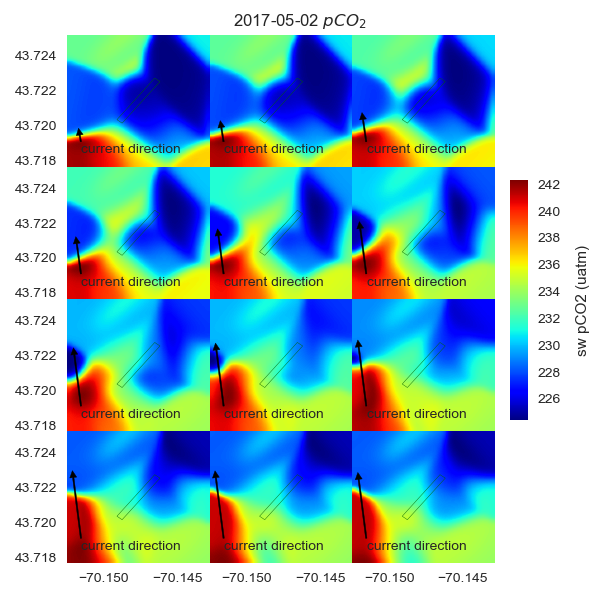

/Users/Mike/anaconda/lib/python3.5/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


Text(0.5,0.98,'2017-05-02 $pCO_2$')

In [9]:
tides_df_path = 'Tidal_Current Data/CAB1409_prediction_Timeseries_2017-05-02_cleaned.csv'
graph_data('FLO_L3_20170317_corrected.csv', tides_df_path=tides_df_path, use_corrected_coords=False)
plt.suptitle('2017-05-02 $pCO_2$')

<IPython.core.display.Javascript object>


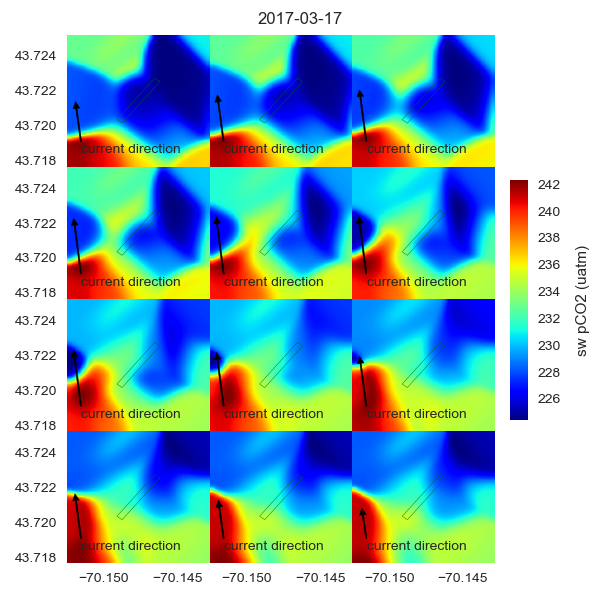

/Users/Mike/anaconda/lib/python3.5/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


Text(0.5,0.98,'2017-03-17')

In [11]:
tides_df_path = 'Tidal_Current Data/CAB1409_prediction_Timeseries_2017-03-17_cleaned.csv'
graph_data('FLO_L3_20170317_corrected.csv', tides_df_path=tides_df_path, use_corrected_coords=False)
plt.suptitle('2017-03-17')

<IPython.core.display.Javascript object>


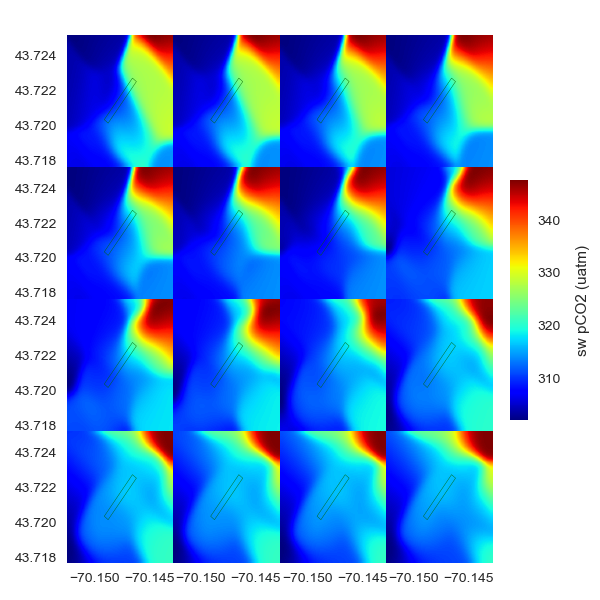

/Users/Mike/anaconda/lib/python3.5/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


In [8]:
graph_data('FLO_L3_20170502.csv', column_to_graph='sw pCO2 (uatm)', graph_size=(4,4), fig_size=(6,6), use_time=True)

<IPython.core.display.Javascript object>


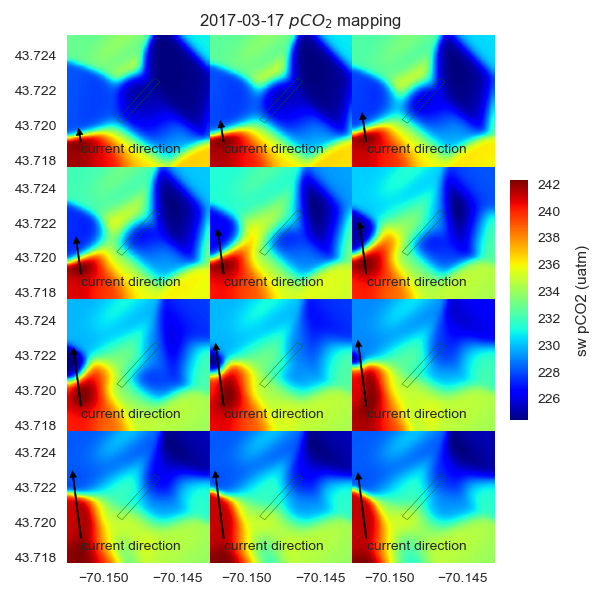

/Users/Mike/anaconda/lib/python3.5/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


In [8]:
tides_df_path = 'Tidal_Current Data/CAB1409_prediction_Timeseries_2017-05-02_cleaned.csv'
fig = graph_data('FLO_L3_20170317.csv', tides_df_path=tides_df_path, title='2017-03-17 $pCO_2$ mapping')

<IPython.core.display.Javascript object>


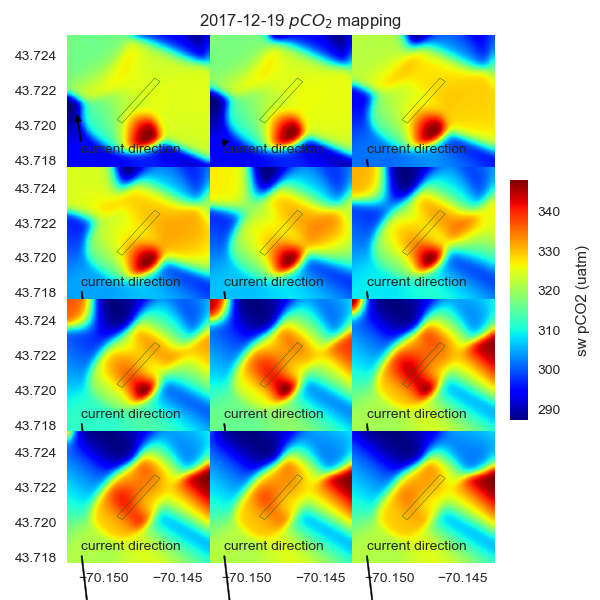

/Users/Mike/anaconda/lib/python3.5/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


In [10]:
tides_df_path = 'Tidal_Current Data/CAB1409_prediction_Timeseries_2017-12-19_cleaned.csv'
graph_data('FLO_L3_20171219_CascoBay_Dec2017_2sec.csv', tides_df_path=tides_df_path, title='2017-12-19 $pCO_2$ mapping')

<IPython.core.display.Javascript object>


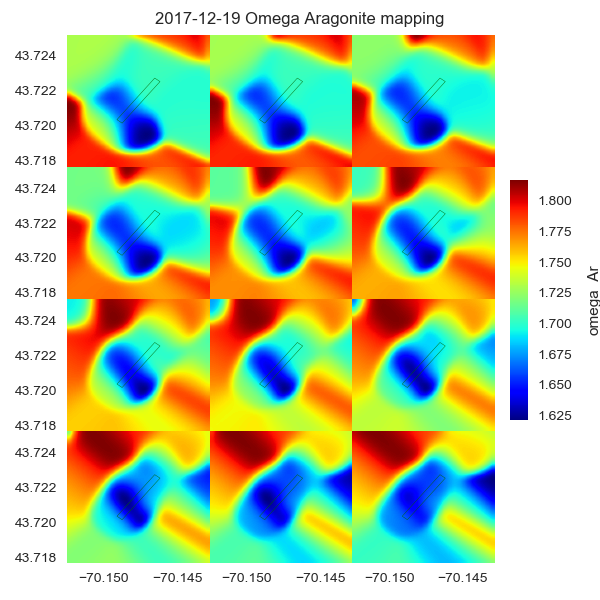

/Users/Mike/anaconda/lib/python3.5/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


In [11]:
graph_data('FLO_L3_CascoBay20171219_revised.csv', column_to_graph='omega_Ar', title='2017-12-19 Omega Aragonite mapping')

<IPython.core.display.Javascript object>


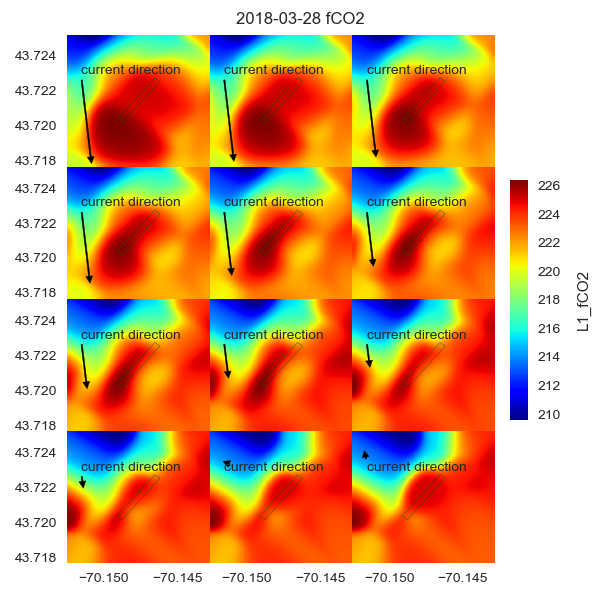

/Users/Mike/anaconda/lib/python3.5/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


Text(0.5,0.98,'2018-03-28 fCO2')

In [12]:
tides_df_path = 'Tidal_Current Data/CAB1409_prediction_Timeseries_2018-03-28_cleaned.csv'
graph_data('FLO_L3_CascoBay20180328.csv', column_to_graph='L1_fCO2', remove_outliers=True, 
           current_arrow_center=(0.1, 0.7), tides_df_path=tides_df_path)
plt.suptitle('2018-03-28 fCO2')

<IPython.core.display.Javascript object>


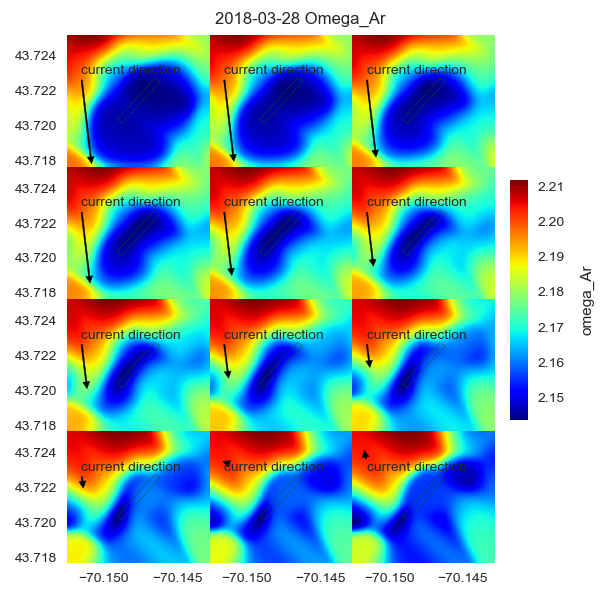

/Users/Mike/anaconda/lib/python3.5/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


Text(0.5,0.98,'2018-03-28 Omega_Ar')

In [13]:
tides_df_path = 'Tidal_Current Data/CAB1409_prediction_Timeseries_2018-03-28_cleaned.csv'
graph_data('FLO_L3_CascoBay20180328.csv', column_to_graph='omega_Ar', tides_df_path=tides_df_path, 
           remove_outliers=True, current_arrow_center=(0.1, 0.7))
plt.suptitle('2018-03-28 Omega_Ar')

<IPython.core.display.Javascript object>


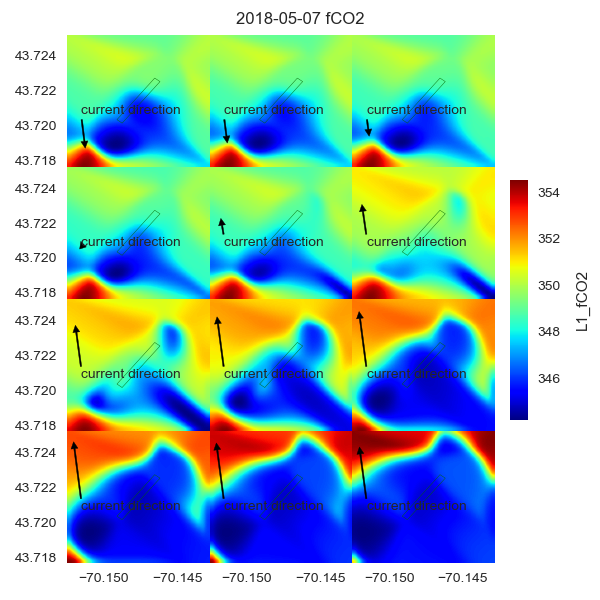

/Users/Mike/anaconda/lib/python3.5/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


Text(0.5,0.98,'2018-05-07 fCO2')

In [14]:
tides_df_path = 'Tidal_Current Data/CAB1409_prediction_Timeseries_2018-05-07_cleaned.csv'
graph_data('FLO_L3_CascoBay20180507_corrected.csv', column_to_graph='L1_fCO2', remove_outliers=True, 
           tides_df_path=tides_df_path, current_arrow_center=(0.1, 0.4))
plt.suptitle('2018-05-07 fCO2')

<IPython.core.display.Javascript object>


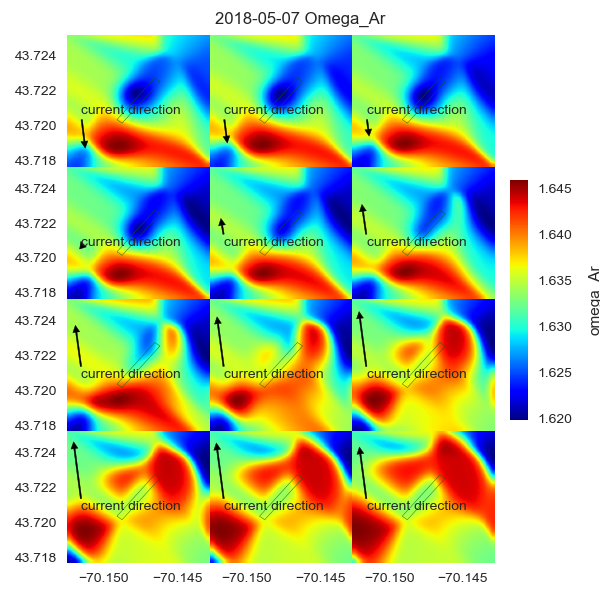

/Users/Mike/anaconda/lib/python3.5/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


Text(0.5,0.98,'2018-05-07 Omega_Ar')

In [15]:
tides_df_path = 'Tidal_Current Data/CAB1409_prediction_Timeseries_2018-05-07_cleaned.csv'
graph_data('FLO_L3_CascoBay20180507.csv', column_to_graph='omega_Ar', remove_outliers=True, 
           tides_df_path=tides_df_path, current_arrow_center=(0.1, 0.4))
plt.suptitle('2018-05-07 Omega_Ar')

In [22]:
pd.read_csv('FLO_L3_CascoBay20171219_revised_corrected.csv').columns

Index(['/fields=year', 'month', 'day', 'secDay', 'Lat', 'Lon', 'Heading',
       'Speed (m/s)', 'Wt', 'cond', 'sal', 'stimfCDOM', 'stimf', 'c660',
       'SBE43_oxygen', 'pressure_atm', 'L1_fCO2', 'L2_fCO2', 'omega_Ar',
       'omega_Ca', 'bottom_flag', 'Heading (rad)', 'dn', 'de',
       'Lon (corrected)', 'Lat (corrected)'],
      dtype='object')

<IPython.core.display.Javascript object>


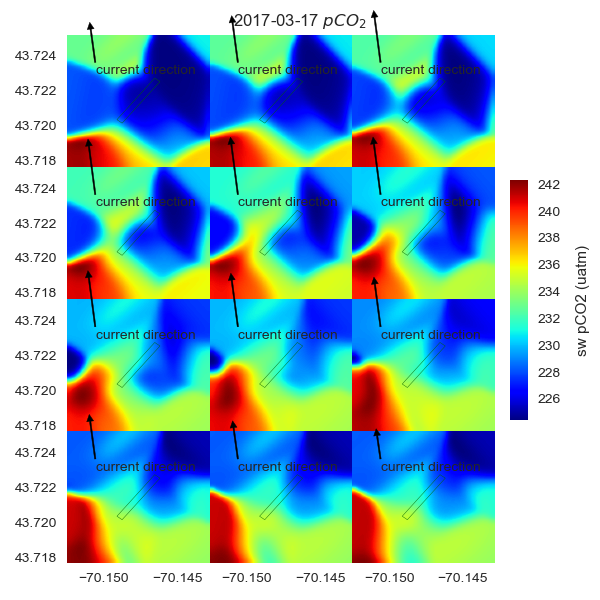

/Users/Mike/anaconda/lib/python3.5/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


In [41]:
date = '2017-03-17'

tides_df_path = 'Tidal_Current Data/CAB1409_prediction_Timeseries_{}_cleaned.csv'.format(date)
graph_data('FLO_L3_20170317_corrected.csv'.format(''.join(date.split('-'))), 
           tides_df_path=tides_df_path, column_to_graph='sw pCO2 (uatm)',
           use_corrected_coords=False, current_arrow_center=(0.2, 0.7))

title = '{} $pCO_2$'.format(date)
plt.suptitle(title)

plt.savefig('Graphs and Visualization/{}_corrected.png'.format(title))

<IPython.core.display.Javascript object>


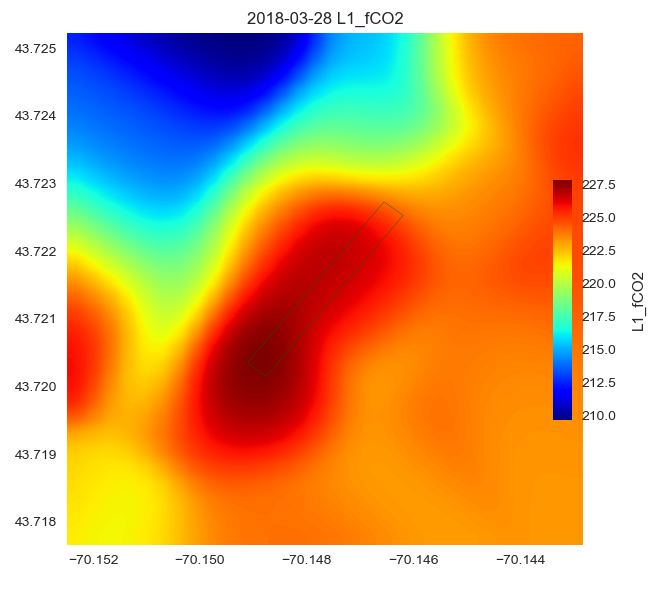

/Users/Mike/anaconda/lib/python3.5/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


In [16]:
graph_data('FLO_L3_CascoBay20180328.csv', column_to_graph='L1_fCO2', remove_outliers=True, 
           fig_size=(6.5,6), graph_size=(1,1), use_time=False)
plt.suptitle('2018-03-28 L1_fCO2')
plt.tight_layout(rect=[0, 0.03, 0.92, 0.97])

<IPython.core.display.Javascript object>


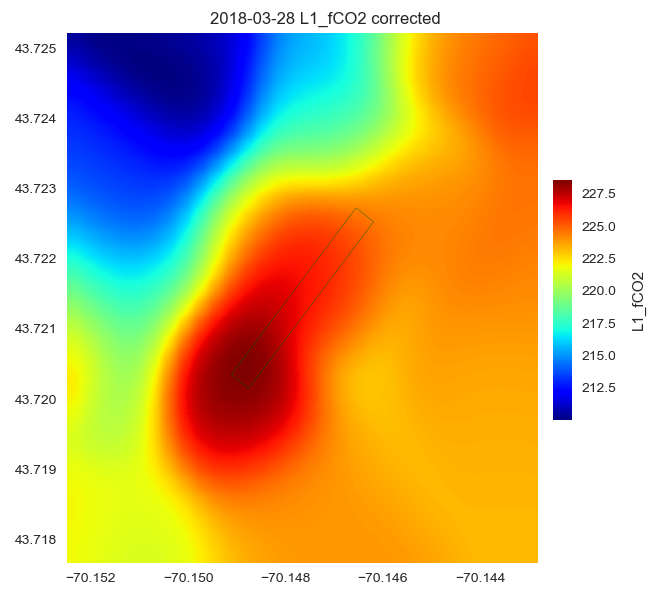

/Users/Mike/anaconda/lib/python3.5/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


Text(0.5,0.98,'2018-03-28 L1_fCO2 corrected')

In [17]:
graph_data('FLO_L3_CascoBay20180328_corrected.csv', column_to_graph='L1_fCO2', remove_outliers=True, 
           fig_size=(6.5,6), graph_size=(1,1), use_time=False, use_corrected_coords=True)
plt.suptitle('2018-03-28 L1_fCO2 corrected')

<IPython.core.display.Javascript object>


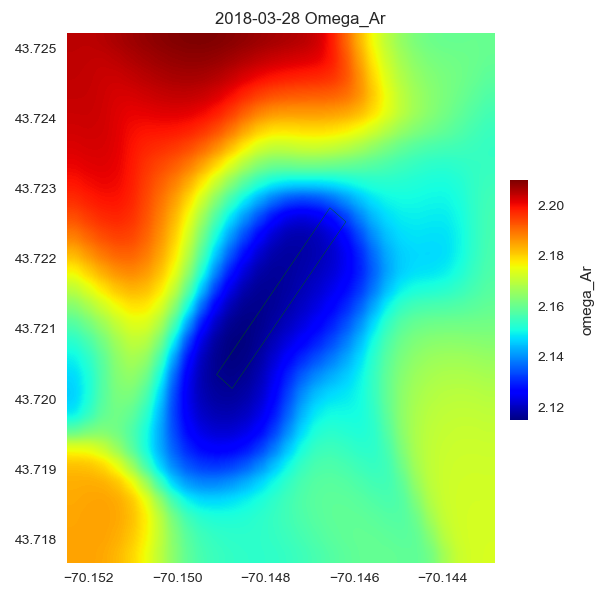

/Users/Mike/anaconda/lib/python3.5/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


Text(0.5,0.98,'2018-03-28 Omega_Ar')

In [18]:
graph_data('FLO_L3_CascoBay20180328.csv', column_to_graph='omega_Ar', remove_outliers=True, 
           fig_size=(6,6), graph_size=(1,1), use_time=False)
plt.suptitle('2018-03-28 Omega_Ar')

<IPython.core.display.Javascript object>


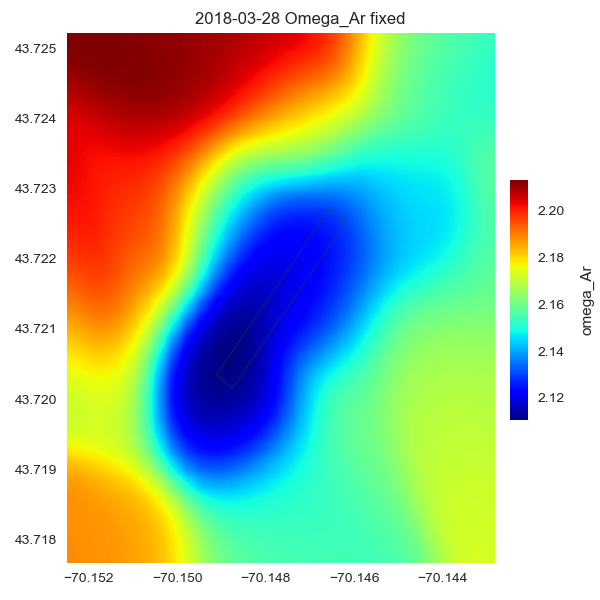

/Users/Mike/anaconda/lib/python3.5/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


Text(0.5,0.98,'2018-03-28 Omega_Ar fixed')

In [19]:
graph_data('FLO_L3_CascoBay20180328_corrected.csv', column_to_graph='omega_Ar', remove_outliers=True, 
           fig_size=(6,6), graph_size=(1,1), use_time=False, use_corrected_coords=True)
plt.suptitle('2018-03-28 Omega_Ar fixed')

<IPython.core.display.Javascript object>


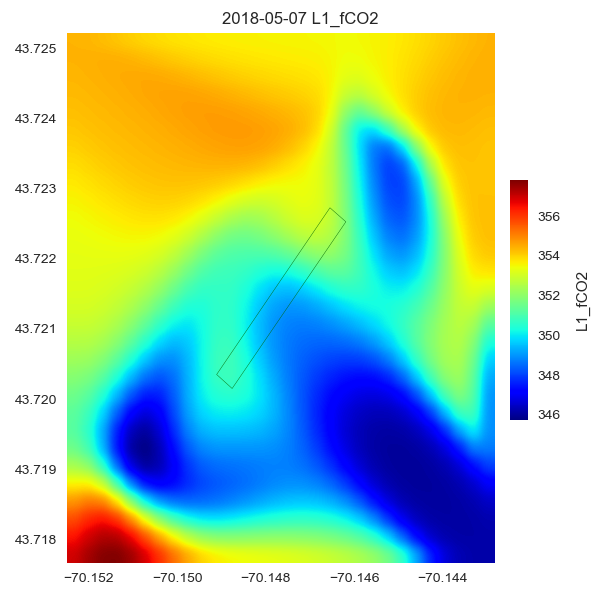

/Users/Mike/anaconda/lib/python3.5/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


Text(0.5,0.98,'2018-05-07 L1_fCO2')

In [20]:
graph_data('FLO_L3_CascoBay20180507.csv', column_to_graph='L1_fCO2', remove_outliers=True, 
           fig_size=(6,6), graph_size=(1,1), use_time=False)
plt.suptitle('2018-05-07 L1_fCO2')

<IPython.core.display.Javascript object>


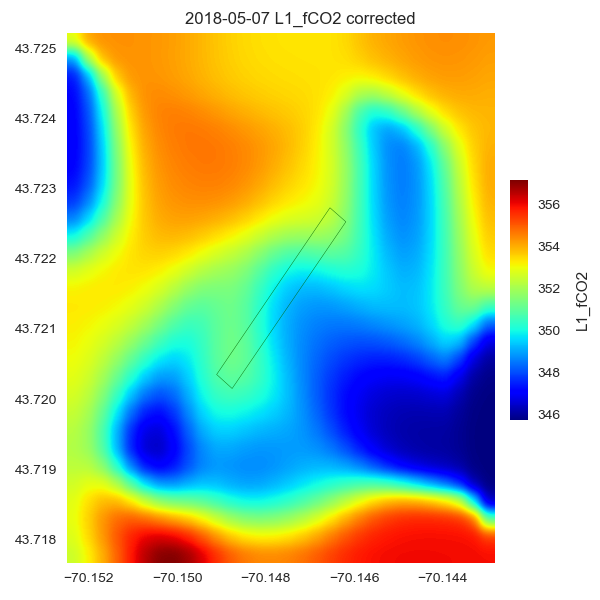

/Users/Mike/anaconda/lib/python3.5/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


Text(0.5,0.98,'2018-05-07 L1_fCO2 corrected')

In [21]:
graph_data('FLO_L3_CascoBay20180507_corrected.csv', column_to_graph='L1_fCO2', remove_outliers=True, 
           fig_size=(6,6), graph_size=(1,1), use_time=False, use_corrected_coords=True)
plt.suptitle('2018-05-07 L1_fCO2 corrected')

<IPython.core.display.Javascript object>


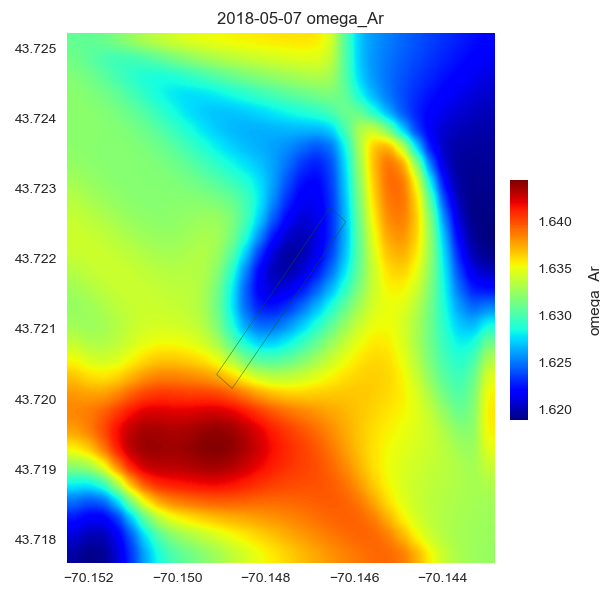

/Users/Mike/anaconda/lib/python3.5/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


Text(0.5,0.98,'2018-05-07 omega_Ar')

In [22]:
graph_data('FLO_L3_CascoBay20180507.csv', column_to_graph='omega_Ar', remove_outliers=True, 
           fig_size=(6,6), graph_size=(1,1), use_time=False)
plt.suptitle('2018-05-07 omega_Ar')

<IPython.core.display.Javascript object>


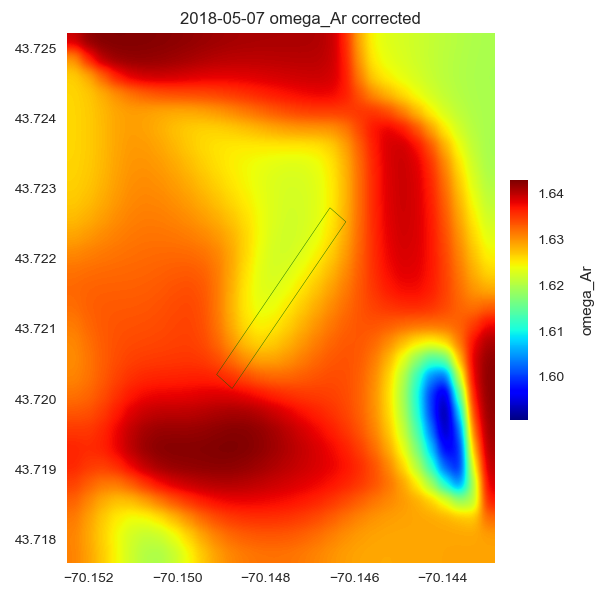

/Users/Mike/anaconda/lib/python3.5/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


Text(0.5,0.98,'2018-05-07 omega_Ar corrected')

In [23]:
graph_data('FLO_L3_CascoBay20180507_corrected.csv', column_to_graph='omega_Ar', remove_outliers=True, 
           fig_size=(6,6), graph_size=(1,1), use_time=False, use_corrected_coords=True)
plt.suptitle('2018-05-07 omega_Ar corrected')

# Saving Corrected lat / lon coords

In [27]:
files = ['FLO_L3_20170317_corrected.csv', 
         'FLO_L3_20170502_corrected.csv', 
         'FLO_L3_20171219_CascoBay_Dec2017_2sec_corrected.csv',
         'FLO_L3_CascoBay20180328_corrected.csv',
         'FLO_L3_CascoBay20180507_corrected.csv'
        ]

dates = [
    '2017-03-17',
    '2017-05-02',
    '2017-12-19',
    '2018-03-28',
    '2018-05-07',
]

tidal_data = ['Tidal_Current Data/CAB1409_prediction_Timeseries_{}_cleaned.csv'.format(date) for date in dates]

titles = ['{} Corrected pCO2'.format(date) for date in dates[:3]] + ['{} Corrected fCO2'.format(date) for date in dates[3:]]

columns = ['sw pCO2 (uatm)'] * 3 + ['L1_fCO2'] * 2

centers = [(0.1, h) for h in [0.1, 0.1, 0.7, 0.8, 0.5]]

## Single Frame

<IPython.core.display.Javascript object>


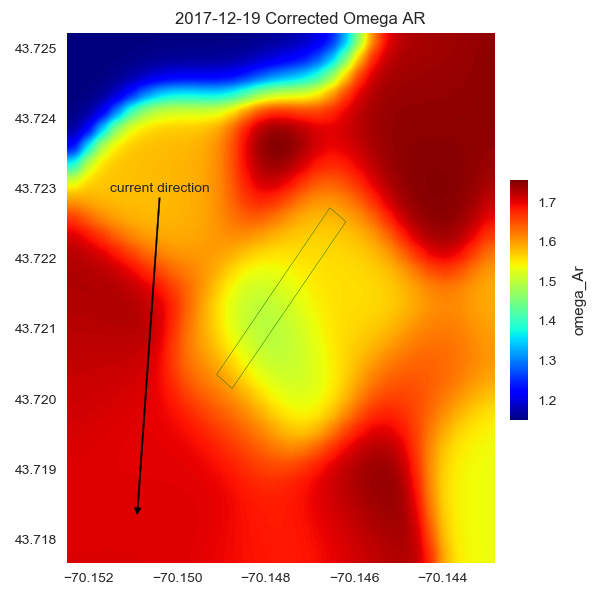

/Users/Mike/anaconda/lib/python3.5/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


<IPython.core.display.Javascript object>


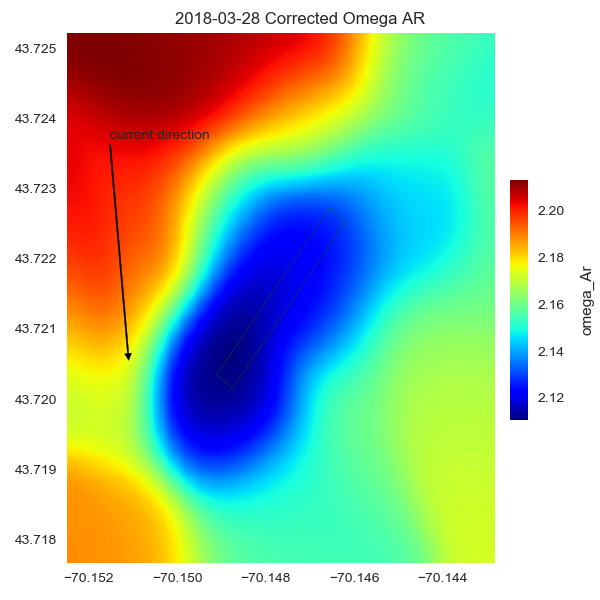

<IPython.core.display.Javascript object>


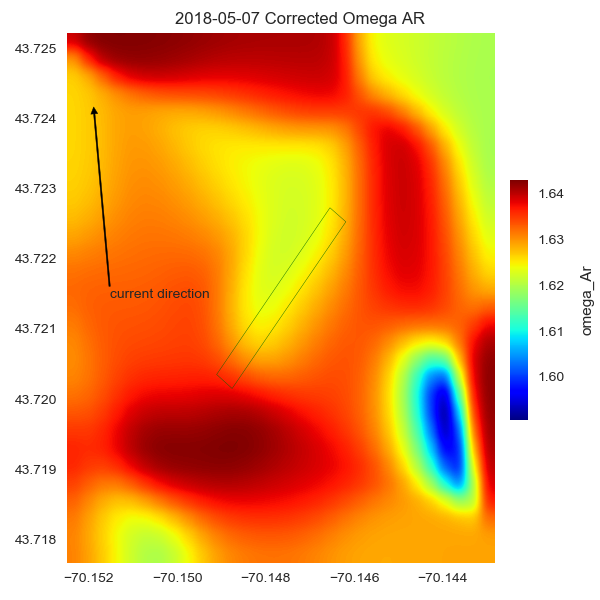

In [25]:
for file, col, title, tidal_path, center in zip(files, columns, titles, tidal_data, centers):
    graph_data(file, column_to_graph=col, remove_outliers=True, title=title, 
               use_corrected_coords=True, tides_df_path=tidal_path, current_arrow_center=center,
               fig_size=(6,6), graph_size=(1,1), use_time=False)
    
    plt.savefig('graphs/{}.png'.format(title), bbox_inches='tight')

<IPython.core.display.Javascript object>


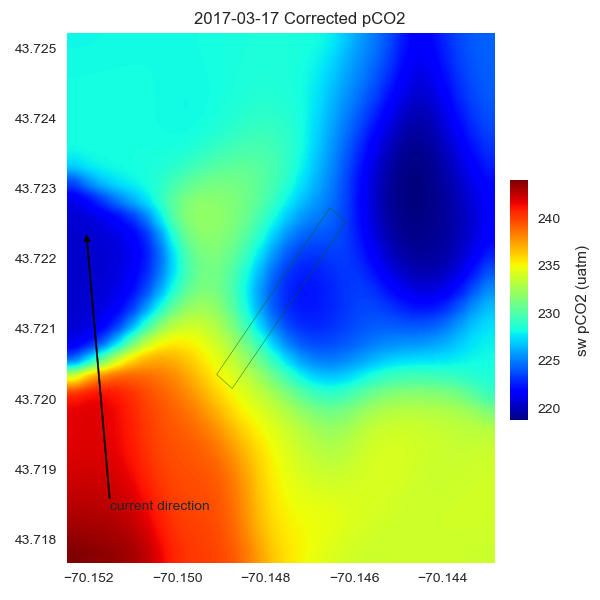

/Users/Mike/anaconda/lib/python3.5/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


<IPython.core.display.Javascript object>


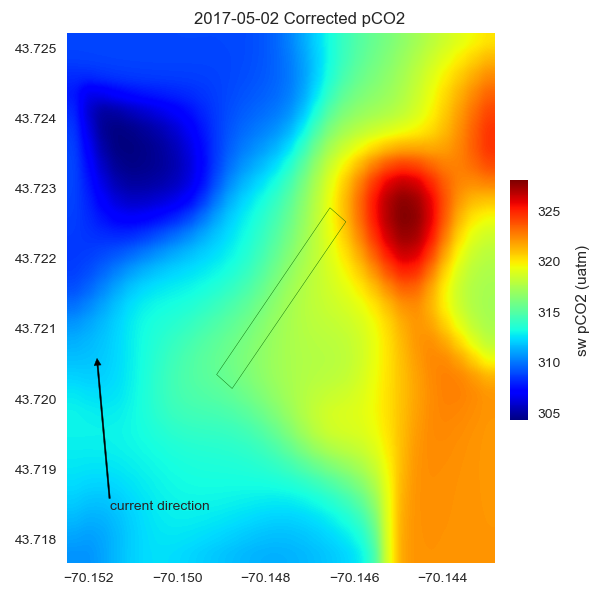

<IPython.core.display.Javascript object>


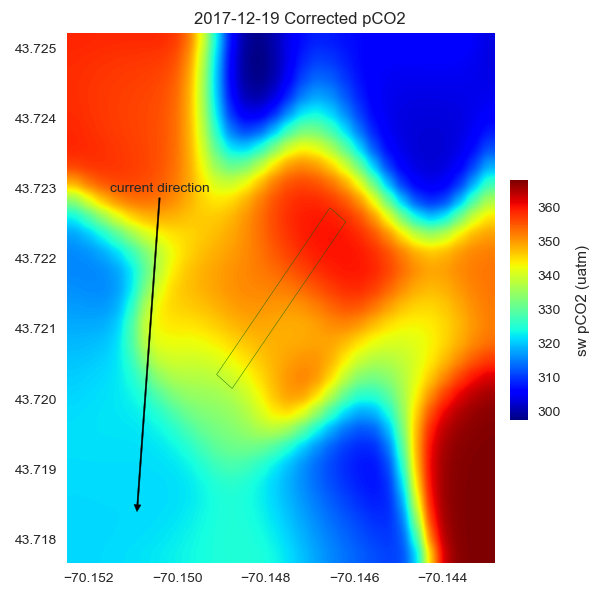

<IPython.core.display.Javascript object>


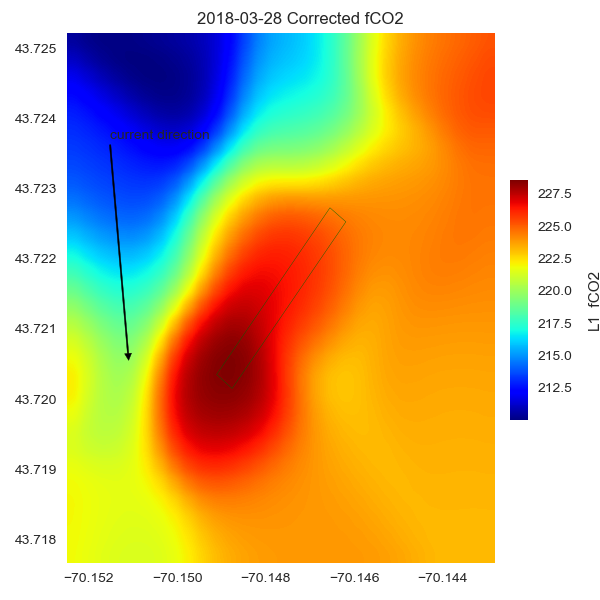

<IPython.core.display.Javascript object>


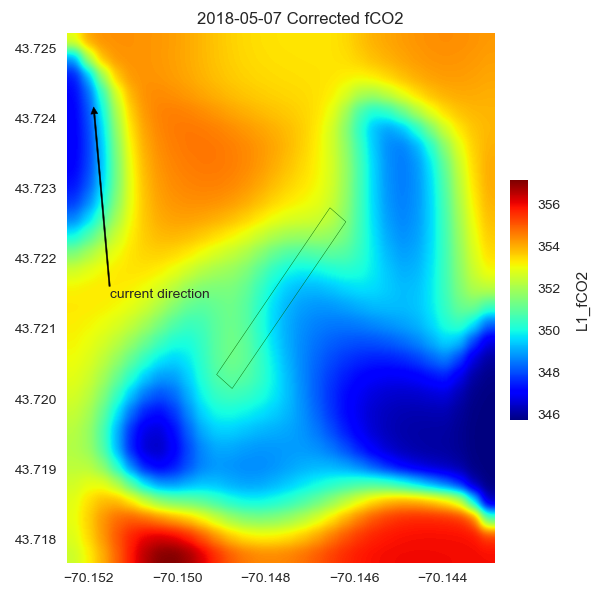

In [29]:
for file, col, title, tidal_path, center in zip(files, columns, titles, tidal_data, centers):
    graph_data(file, column_to_graph=col, remove_outliers=True, title=title, 
               use_corrected_coords=True, tides_df_path=tidal_path, current_arrow_center=center,
               fig_size=(6,6), graph_size=(1,1), use_time=False)
    
    plt.savefig('graphs/{}_single_frame.png'.format(title), bbox_inches='tight')

# Omega AR

In [34]:
files = ['FLO_L3_CascoBay20171219_revised_corrected.csv',
         'FLO_L3_CascoBay20180328_corrected.csv',
         'FLO_L3_CascoBay20180507_corrected.csv'
        ]

tidal_data = tidal_data[-3:]
centers = centers[-3:]

columns = ['omega_Ar'] * 3
titles = ['{} Corrected Omega AR'.format(date) for date in dates[2:]]


In [ ]:
for file, col, title, tidal_path in zip(files, columns, titles, tidal_data):
    graph_data(file, column_to_graph=col, remove_outliers=True, title=title, 
               use_corrected_coords=True, tides_df_path=tidal_path)

    plt.savefig('graphs/{}.png'.format(title), bbox_inches='tight')

## Single Frame

<IPython.core.display.Javascript object>


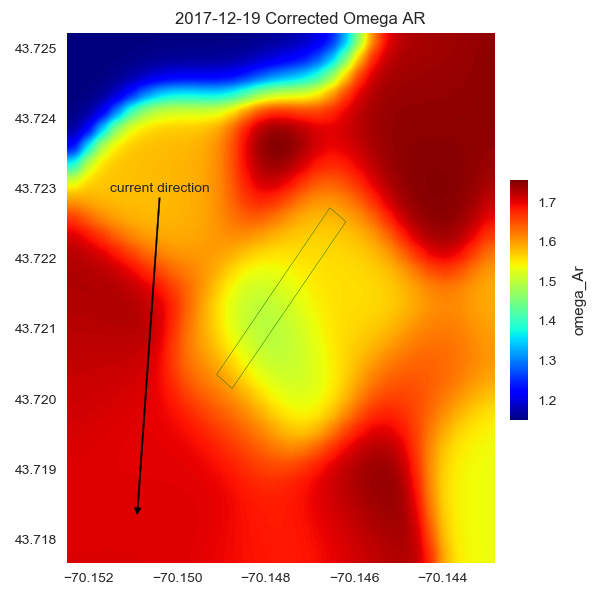

/Users/Mike/anaconda/lib/python3.5/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


<IPython.core.display.Javascript object>


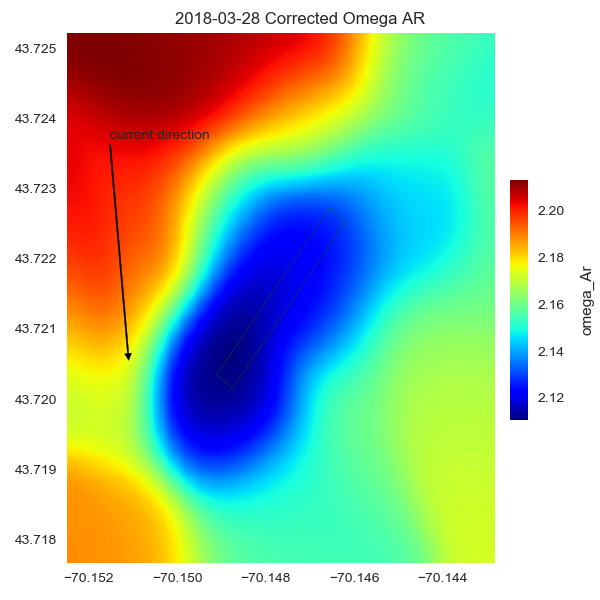

<IPython.core.display.Javascript object>


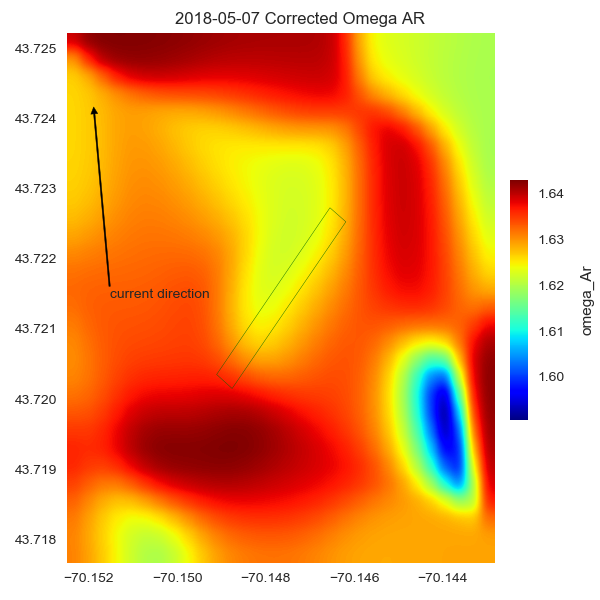

In [35]:
for file, col, title, tidal_path, center in zip(files, columns, titles, tidal_data, centers):
    graph_data(file, column_to_graph=col, remove_outliers=True, title=title, 
               use_corrected_coords=True, tides_df_path=tidal_path, current_arrow_center=center,
               fig_size=(6,6), graph_size=(1,1), use_time=False)
    
    plt.savefig('graphs/{}_single_frame.png'.format(title), bbox_inches='tight')

# Visualizing O2

In [146]:
pd.read_csv('FLO_L3_CascoBay20180328.csv').columns

Index(['month', 'day', 'secDay', 'Lat', 'Lon', 'heading', 'speed', 'Wt',
       'cond', 'sal', 'stimfCDOM', 'stimf', 'c660', 'SBE43_oxygen',
       'pressure_atm', 'L1_fCO2', 'L2_fCO2', 'omega_Ar', 'omega_Ca',
       'bottom_flag'],
      dtype='object')

In [145]:
# # Cleans the data
# for link in ['FLO_L3_CascoBay20180328.csv', 'FLO_L3_CascoBay20180507.csv', 'FLO_L3_CascoBay20171219_revised.csv']:
#     df = pd.read_csv(link)
#     df.loc[-1] = [None] * len(df.columns) # add empty row to align with the others
#     df.index = df.index + 1  # shifting index
#     df = df.sort_index()  # sorting by index
#     df.rename(index=str, columns=dict(lat='Lat', lon='Lon'), inplace=True)
#     df.to_csv(link, index=False)
    